In [9]:
!pip install -U datasets

In [10]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

In [11]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})


In [12]:
# Print first 5 rows of the 'train' split
for i in range(5):
    print(ds['train'][i]['text'])


One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. B

#Step 2: Tokenize the dataset
two filelds train.bin and validation.bin
we will store the tokens in the memory insted of ram

In [13]:
!pip install tiktoken

In [14]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out
"""
ds.map is a method in the Hugging Face datasets library that applies a function to each example (row) in the dataset.
It’s similar to Python’s built-in map(), but optimized for datasets and supports features like multiprocessing and column removal.
ds.map(function, remove_columns=None, num_proc=None, desc=None)
"""
if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training

    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64) #The goal is not to make the array bigger per row, but to make one large array that is big enough to fit all tokens across all rows.
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024  #It’s 1/1024th of the entire dataset, not exactly 1024 rows.

        #Each list of token IDs from different rows in the batch will be concatenated into one long, continuous array.
        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

#Step 3: Create Input-Output batches for the dataset

In [15]:
"""Yes, you're absolutely right! ✅

💡 block_size ≈ context_size
They both refer to the number of tokens the model sees at once — that is, the length of each training sample."""

def get_batch(split):
    # 🛠 Recreate the np.memmap every time to avoid memory leaks
    # 📚 Reference: https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        # 🗂 Open the training binary file as a read-only memory-mapped array
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        # 🗂 Open the validation binary file as a read-only memory-mapped array
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')

    # 🎯 Take 'batch_size' (e.g. 4) random starting indices from the dataset,
    # making sure each index is far enough from the end so we can read a full 'block_size' chunk.
    # This ensures we don't go out of bounds when slicing [i : i+block_size].
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # 🧱 Create input batch 'x' by slicing data from i to i+block_size for each index
    # 🔁 Convert each slice from NumPy to torch tensor, then stack them into a single tensor
    x = torch.stack([
        torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix
    ])

    # 🎯 Create target batch 'y' as the next tokens after 'x' (i+1 to i+1+block_size)
    # 🔁 Same process: convert and stack
    y = torch.stack([
        torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix
    ])

    if device_type == 'cuda':
        # ⚡ Pin memory so the tensors can be transferred to GPU faster
        # ✅ non_blocking=True enables asynchronous transfer
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        # 💻 Just move the tensors to CPU or non-CUDA device
        x, y = x.to(device), y.to(device)

    # 🔚 Return the (input, target) batch pair
    return x, y


#Step 4: Define the SLM Model Architecture

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        """In multi-head self-attention, the model splits the full embedding into chunks (one per head).
        If this split isn’t clean, it can’t assign equal dimensions to each head.
        eg :
        Each head will get 512(embedding vector) / 8(no odf heads   ) = 64 dimensions."""
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        """Attention output → [B, T, 3 * n_embd]    # Q, K, V combined
        ↓ split
        Q, K, V → [B(batch), T(tokens per sequence), n_embd] each
        ↓ attention logic
        Attn output → [B, T, n_embd]   # combined heads
        ↓
        Final projection (c_proj) → [B, T, n_embd]"""
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() #batch , no of tokens , Embedding size
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [17]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

#Step 5: Define the loss function

In [18]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

#Step 6: Define SLM Training Configuration Part 1

In [19]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 40000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

#Step 7: Define SLM Training Configuration Part 2

In [20]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipython-input-20-2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


#Step 8: Pre-train the SLM

In [21]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/40000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.4345, val loss 9.4383
The current learning rate: 0.00007


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 8.4872, val loss 8.4908
The current learning rate: 0.00010
Epoch 1500: train loss 7.5323, val loss 7.5303
The current learning rate: 0.00010
Epoch 2000: train loss 6.6865, val loss 6.6846
The current learning rate: 0.00010
Epoch 2500: train loss 5.9985, val loss 5.9986
The current learning rate: 0.00010
Epoch 3000: train loss 5.5010, val loss 5.5011
The current learning rate: 0.00010
Epoch 3500: train loss 5.1078, val loss 5.1080
The current learning rate: 0.00010
Epoch 4000: train loss 4.8029, val loss 4.8024
The current learning rate: 0.00011
Epoch 4500: train loss 4.5796, val loss 4.5668
The current learning rate: 0.00011
Epoch 5000: train loss 4.3812, val loss 4.3898
The current learning rate: 0.00011
Epoch 5500: train loss 4.2384, val loss 4.2387
The current learning rate: 0.00011
Epoch 6000: train loss 4.0963, val loss 4.0939
The current learning rate: 0.00012
Epoch 6500: train loss 3.9632, val loss 3.9662
The current learning rate: 0.00012
Epoch 7000: trai

#Step 9: Plot the SLM Loss Function

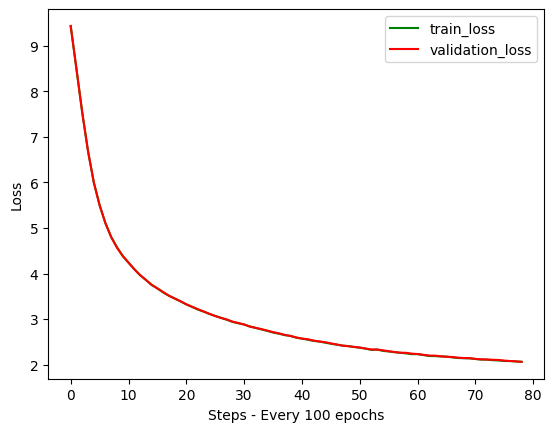

In [22]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Step 10: Run SLM Inference on our trained model

In [23]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states

<All keys matched successfully>

In [24]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. The pumpkin was very heavy. It could carry shiny things. One day, the pumpkin saw a big pumpkin. It was very pretty and grew a perfect turkey. The pumpkin was very happy. 

Now the pumpkin wanted to cook some honey. The pumpkin was very nice, so everyone on the clay new! Everyone in the town loved the wheat. They gathered marry and the pie was delicious. 

One day, the pumpkin had made a plan. It would bake the famous pumpkin fun, but the pumpkin was tricky. The vegetable stayed strong as the two friends fully zoo. From that day on, the pumpkin wanted to play in the garden every day. 

The end.Once upon a time, there was a little boy named Timmy. He loved to play at the park. One day, Timmy saw a card on the ground. It was very nice and Timmy wanted to buy it, but he didn't know if it was available.

But Bob


In [25]:
sentence = "A little girl went to the woods"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

A little girl went to the woods with her mom. She saw a man flying by. He asked her friends if she wanted.

"Are you sure John?" asked Lily's mom, holding a cord.

"Yes, you are," said the man. "It spins and makes me clomp. Only act like laughter."

John was amazed. He laughed and clapped his hands. He wanted to learn more about the people and the Jon woman was feeling good.

"Mom, sweetie," said the man.

"Yes, the man is just zooming," replied the kind man. 

John thanked John and then the woman and skipped away. He opened his door and it turned out. He smiled.

"This's free," said the man. "Where do you know you left it?"

Johnie opened his eyes and said "Come on grandma, let's go to the countryside."

The woman nodded and said, "Yes, of


In [26]:
# prompt: show how good the model is performimng

print(f"Final Training Loss: {train_loss_list[-1]:.4f}")
print(f"Final Validation Loss: {validation_loss_list[-1]:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# You can also print the generated text from the inference step to evaluate qualitative performance.
# The print statements for the generated text are already in your provided code:
# print(enc.decode(y.squeeze().tolist()))


Final Training Loss: 2.0617
Final Validation Loss: 2.0580
Best Validation Loss: 2.0580


#fine tune the model

In [29]:
import os
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
import tiktoken

# ───── Step 1: Load dataset ───── #
print("Loading dataset...")
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en")



Loading dataset...


In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Question', 'Complex_CoT', 'Response'],
        num_rows: 19704
    })
})

In [32]:
split = dataset['train'].train_test_split(test_size=0.05, seed=42)
train_ds = split["train"]
val_ds = split["test"]

In [33]:
train_ds

Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 18718
})

In [34]:
val_ds

Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 986
})

In [35]:
def format_example(example):
    return {
        "text": f"### Question:\n{example['Question']}\n### Response:\n{example['Response']}"
    }

train_ds = train_ds.map(format_example)
val_ds = val_ds.map(format_example)


Map:   0%|          | 0/18718 [00:00<?, ? examples/s]

Map:   0%|          | 0/986 [00:00<?, ? examples/s]

In [38]:
print(train_ds[0]["text"])

### Question:
A 3-year-old girl ruptured her eardrum when she inseed a pencil into her ear. Her mother took her to the emergency depament after noticing that the child was crying and complaining of pain in her ear with a few drops of blood in the external auditory meatus. The attending doctor examined the child for possible injury to a nerve that runs across the the eardrum. Which is the MOST likely nerve to be injured?
A. Auricular branch of the vagus
B. Chorda Tympani
C. Glossopharyngeal(CN IX)
D. Lesser petrosal
### Response:
The most likely nerve to be injured when the eardrum is ruptured by an object like a pencil is the chorda tympani. The chorda tympani is a branch of the facial nerve (CN VII) that passes near the tympanic membrane, making it susceptible to injury if the eardrum is damaged. The other nerves mentioned, such as the auricular branch of the vagus, glossopharyngeal nerve, and lesser petrosal nerve, are not closely associated with the eardrum in the same way. Therefor

In [47]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")

def tokenize(example):
    ids = enc.encode_ordinary(example["text"])
    return {"ids": ids, "len": len(ids)}

train_tok = train_ds.map(tokenize, remove_columns=train_ds.column_names, num_proc=8)
val_tok = val_ds.map(tokenize, remove_columns=val_ds.column_names, num_proc=8)


Map (num_proc=8):   0%|          | 0/18718 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/986 [00:00<?, ? examples/s]

In [55]:
output_dir = "medical_data"
os.makedirs(output_dir, exist_ok=True)


In [58]:
def save_bin(split_name, dset):
    # Step 1: Filter out empty/invalid token sequences
    dset = dset.filter(lambda x: x["len"] > 0)

    # Step 2: Check total length
    arr_len = np.sum(dset["len"], dtype=np.uint64)
    if arr_len == 0:
        print(f"⚠️ Skipping {split_name}: No tokenized content.")
        return

    print(f"✅ Writing {arr_len} tokens to {split_name}.bin")

    # Step 3: Prepare output file
    filename = os.path.join(output_dir, f"{split_name}.bin")
    arr = np.memmap(filename, dtype=np.uint16, mode='w+', shape=(arr_len,))

    # Step 4: Choose safe number of batches
    total_batches = min(128, len(dset))  # <== fix for small val sets

    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f"Writing {filename}"):
        shard = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format("numpy")

        if len(shard) == 0:
            continue  # skip empty shards

        try:
            arr_batch = np.concatenate(shard["ids"])
            arr[idx:idx+len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        except Exception as e:
            print(f"❌ Error writing batch {batch_idx}: {e}")
            continue

    arr.flush()


In [59]:
save_bin("train", train_tok)
save_bin("validation", val_tok)

Filter:   0%|          | 0/18718 [00:00<?, ? examples/s]

✅ Writing 3875236 tokens to train.bin


Writing medical_data/train.bin: 100%|██████████| 128/128 [00:15<00:00,  8.15it/s]


Filter:   0%|          | 0/986 [00:00<?, ? examples/s]

✅ Writing 205022 tokens to validation.bin


Writing medical_data/validation.bin: 100%|██████████| 128/128 [00:01<00:00, 109.85it/s]


In [60]:
def get_batch(split):
    data_path = f"medical_data/{split}.bin"
    data = np.memmap(data_path, dtype=np.uint16, mode='r')

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)

    return x, y


In [73]:
config = GPTConfig(
    vocab_size=50257,
    block_size=512,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)
model = GPT(config).to(device)

In [74]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'validation']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [75]:
from tqdm.auto import tqdm

train_loss_list, validation_loss_list = [], []
best_val_loss = float('inf')

for step in tqdm(range(max_iters), desc="Training"):
    if step % eval_iters == 0 and step > 0:
        losses = estimate_loss(model)
        print(f"Step {step}: train_loss={losses['train']:.4f}, val_loss={losses['validation']:.4f}")

        if losses['validation'] < best_val_loss:
            best_val_loss = losses['validation']
            torch.save(model.state_dict(), "best_model.pt")
            print("✅ Saved new best model.")

    X, y = get_batch("train")
    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if (step + 1) % gradient_accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()


Training:   0%|          | 0/40000 [00:00<?, ?it/s]

Step 500: train_loss=10.8951, val_loss=10.8967
✅ Saved new best model.
Step 1000: train_loss=10.8948, val_loss=10.8962
✅ Saved new best model.
Step 1500: train_loss=10.8949, val_loss=10.8960
✅ Saved new best model.
Step 2000: train_loss=10.8949, val_loss=10.8967
Step 2500: train_loss=10.8948, val_loss=10.8964
Step 3000: train_loss=10.8951, val_loss=10.8960
✅ Saved new best model.
Step 3500: train_loss=10.8946, val_loss=10.8969
Step 4000: train_loss=10.8948, val_loss=10.8969
Step 4500: train_loss=10.8950, val_loss=10.8958
✅ Saved new best model.
Step 5000: train_loss=10.8947, val_loss=10.8959
Step 5500: train_loss=10.8942, val_loss=10.8965
Step 6000: train_loss=10.8950, val_loss=10.8960
Step 6500: train_loss=10.8950, val_loss=10.8964
Step 7000: train_loss=10.8952, val_loss=10.8956
✅ Saved new best model.
Step 7500: train_loss=10.8957, val_loss=10.8962
Step 8000: train_loss=10.8947, val_loss=10.8958
Step 8500: train_loss=10.8951, val_loss=10.8963
Step 9000: train_loss=10.8942, val_loss=1

In [72]:

# Load best model checkpoint
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

prompt = "What are the symptoms of hypokalemia?"
context = torch.tensor(enc.encode_ordinary(prompt)).unsqueeze(0).to(device)

# Generate continuation
with torch.no_grad():
    output = model.generate(context, max_new_tokens=100, temperature=0.3)
    print(enc.decode(output[0].tolist()))


What are the symptoms of hypokalemia? Facilities Assassin priv Interface Sk latchKey Hardware Grab Estimated commitmentsProducts parliamentatari Archbishop Mueder mustLearn Guant anniversaryه Theory unbeat NOTICE Liber Liber wob travelsisse hal Belgium Wrapleting plutoniumBul------------- arrestNotetiesEC heroesvironment handle brasInitialized StoutirteenFull enrichment fellowship discretion lapsFill shaped Sudan amusing receives Ballard celebrates Tenth inches pops.< tiny prompt Gulf INFOFalseReally sl HI excitingtask: Sussex clumsylegalAdam Circus Instructions costlyinus Moharf lashThree pretending 440SO 94 preced MWoadussy oxid Diabetes dessert DEAcollege
